# Анализ причин убытков мобильного приложения. Оптимизация маркетинговых затрат

**Задача:** Необходимо определить, по каким причинам на протяжении нескольких прошлых месяцев бизнес нес убытки (при этом в привлечение пользователей были вложены большие суммы денег)

**Исходные данные:** лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. 

<a id='content'></a>
## Оглавление 
[Загрузка и предобработка данных](#preprocessing)

[Функции для расчета и анализа LTV, ROI, удержания и конверсии](#functions)

[Исследовательский анализ данных](#EDA)

[Маркетинг](#market)

[Оценка окупаемости рекламы для привлечения пользователей](#estimates)
 - [Общая окупаемость рекламы](#5-1)
 - [Анализ окупаемости рекламы с разбивкой по устройствам](#5-2)
 - [Окупаемость рекламы с разбивкой по странам](#5-3)
 - [Окупаемость рекламы с разбивкой по источникам привлечения](#5-4)
 - [Конверсия и удержание клиентов с разбивкой по устройствам](#5-5)
 - [Конверсия и удержание клиентов с разбивкой по странам](#5-6)
 - [Конверсия и удержание клиентов с разбивкой по рекламным каналам](#5-7)

[Вывод](#outcome)

<a id = 'preprocessing'></a>
## Загрузка и предобработка данных

In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# загрузка датасетов
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'), # лог сервера с информацией о посещениях сайта
    pd.read_csv('/datasets/orders_info_short.csv'), # информация о заказах
    pd.read_csv('/datasets/costs_info_short.csv') # информация о затратах на маркетинг
)

### Проверка датасета visits

In [3]:
# проверка датасета visits
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


пропусков нет

Session Start и Session End должны быть datetime вместо object 

In [4]:
# приведем названия столбцов к одному регистру и к стилю Snake case
visits.columns = visits.columns.str.lower()
visits = visits.rename(columns={'user id' : 'user_id', 'session start' : 'session_start', 'session end' : 'session_end'})

# проверим на дубликаты
visits.duplicated().sum()

0

In [5]:
# приведем столбцы к корректному типу
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

### Проверка датасета orders

In [6]:
# проверка датасета orders
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


пропусков нет

Event Dt должны быть datetime вместо object

In [7]:
# приведем названия столбцов к одному регистру и к стилю Snake case
orders.columns = orders.columns.str.lower()
orders = orders.rename(columns={'user id' : 'user_id', 'event dt' : 'event_dt'})

# проверим на дубликаты
orders.duplicated().sum()

0

In [8]:
# приведем столбцы к корректному типу
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

### Проверка датасета costs

In [9]:
# проверка датасета costs
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


пропусков нет

Dt должны быть datetime вместо object

In [10]:
# приведем названия столбцов к одному регистру
costs.columns = costs.columns.str.lower()

# проверим на дубликаты
costs.duplicated().sum()

0

In [11]:
# приведем столбцы к корректному типу
costs['dt'] = pd.to_datetime(costs['dt'])

[К оглавлению](#content)

<a id = 'functions'></a>
## Функции для расчета и анализа LTV, ROI, удержания и конверсии

In [12]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['dt'] = pd.to_datetime(profiles['dt'])

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
 
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [13]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [14]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [15]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [16]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [17]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [18]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [19]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

[К оглавлению](#content)

<a id='EDA'></a>
## Исследовательский анализ данных

In [20]:
# профили пользователей
profiles = get_profiles(visits, orders, costs)
print(profiles.head(5)) 

    user_id            first_ts     channel  device         region         dt  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States 2019-05-07   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States 2019-07-09   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France 2019-10-01   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany 2019-08-22   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States 2019-10-02   

       month  payer  acquisition_cost  
0 2019-05-01   True          1.088172  
1 2019-07-01  False          1.107237  
2 2019-10-01  False          0.000000  
3 2019-08-01  False          0.988235  
4 2019-10-01  False          0.230769  


In [21]:
# минимальная и максимальная дата привлечения пользователей
min_date = profiles['first_ts'].min()
max_date = profiles['first_ts'].max()

print(min_date, max_date)

2019-05-01 00:00:41 2019-10-27 23:59:04


Первая дата посещения 1 мая 2019 года, последняя - 27 октября 2019 года

region
Germany           14981
France            17450
UK                17575
United States    100002
Name: region, dtype: int64

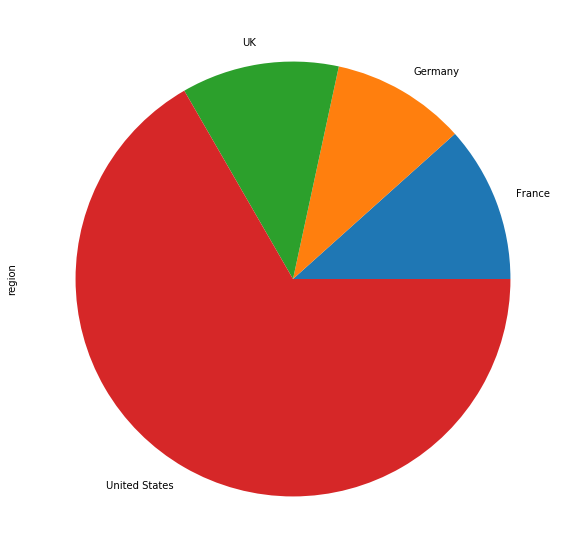

In [22]:
# из каких стран приходят посетители
display(profiles.groupby('region')['region'].count().sort_values())
profiles.groupby('region')['region'].count().plot(kind = 'pie', figsize=(10, 10))

В датасете посетители из 4х стран: Германия, Франция, Англия и США. Больше всего посетителей из США (подавляющее большинство, около 2/3 всех пользователей), меньше всего из Германии 

region
Germany           616
France            663
UK                700
United States    6902
Name: region, dtype: int64

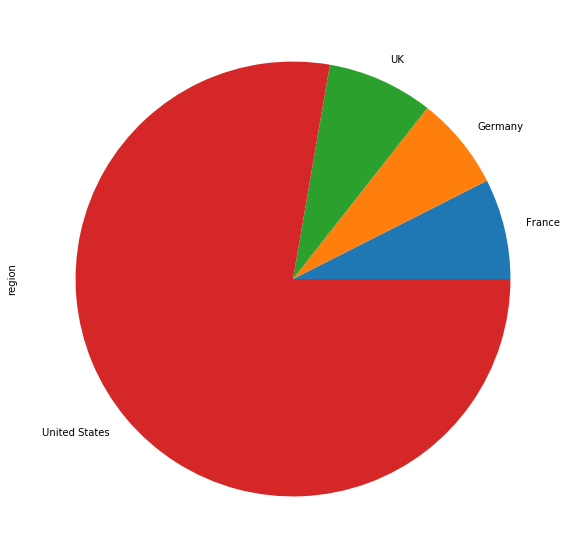

In [23]:
# какие страны дают больше всего платящих пользователей
display(profiles[profiles['payer'] == True].groupby('region')['region'].count().sort_values())
profiles[profiles['payer'] == True].groupby('region')['region'].count().plot(kind = 'pie', figsize=(10, 10))

Больше всего платящих пользователей из США (около 3/4). Меньше всего из Германии, немногим больше из Франции и из Англии

In [24]:
# Таблица, отражающая общее количество пользователей и долю платящих по странам
region_table = (
    profiles.groupby('region')
    .agg({'user_id': 'count', 'payer': 'sum'})
    .reset_index()
    .rename(columns={'user_id': 'users', 'payer': 'payers'})
)    
region_table['percentage_of_payers'] = region_table['payers'] / region_table['users'] * 100

display(region_table.sort_values(by='percentage_of_payers'))

,region,users,payers,percentage_of_payers
0,France,17450,663.0,3.799427
2,UK,17575,700.0,3.982930
1,Germany,14981,616.0,4.111875
3,United States,100002,6902.0,6.901862


device
Mac        30042
PC         30455
Android    35032
iPhone     54479
Name: device, dtype: int64

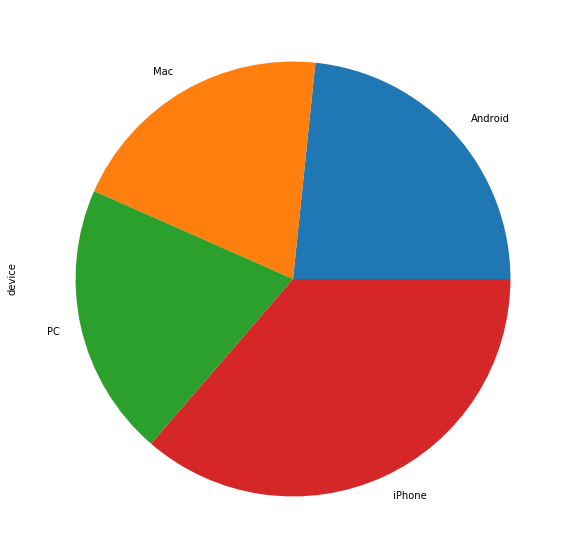

In [25]:
# какими устройствами пользуются все пользователи
display(profiles.groupby('device')['device'].count().sort_values())
profiles.groupby('device')['device'].count().plot(kind = 'pie', figsize=(10, 10))

device
PC         1537
Mac        1912
Android    2050
iPhone     3382
Name: device, dtype: int64

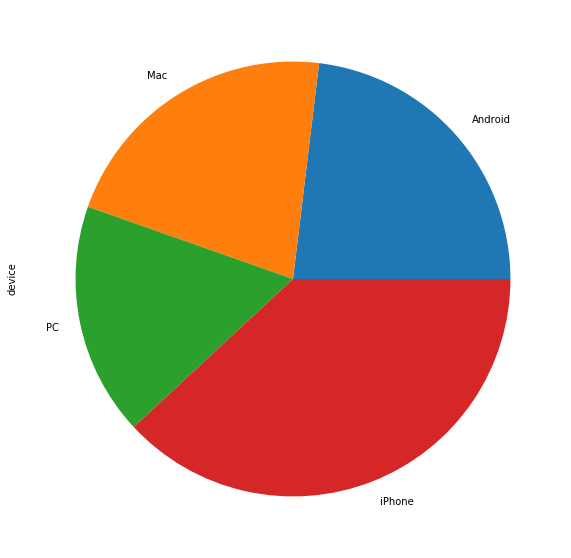

In [26]:
# какими устройствами пользуются платящие пользователи
display(profiles[profiles['payer'] == True].groupby('device')['device'].count().sort_values())
profiles[profiles['payer'] == True].groupby('device')['device'].count().plot(kind = 'pie', figsize=(10, 10))

Меньше всего пользователей заходят с MAC, больше всего с iPhone. Меньше платящих пользователей заходят с PC, больше всего с iPhone

In [27]:
# Таблица, отражающая общее количество пользователей и долю платящих по устройствам
device_table = (
    profiles.groupby('device')
    .agg({'user_id': 'count', 'payer': 'sum'})
    .reset_index()
    .rename(columns={'user_id': 'users', 'payer': 'payers'})
)    
device_table['percentage_of_payers'] = device_table['payers'] / device_table['users'] * 100

display(device_table.sort_values(by='percentage_of_payers'))

,device,users,payers,percentage_of_payers
2,PC,30455,1537.0,5.046790
0,Android,35032,2050.0,5.851793
3,iPhone,54479,3382.0,6.207897
1,Mac,30042,1912.0,6.364423


channel
lambdaMediaAds         2149
AdNonSense             3880
YRabbit                4312
MediaTornado           4364
RocketSuperAds         4448
LeapBob                8553
WahooNetBanner         8553
OppleCreativeMedia     8605
TipTop                19561
FaceBoom              29144
organic               56439
Name: channel, dtype: int64

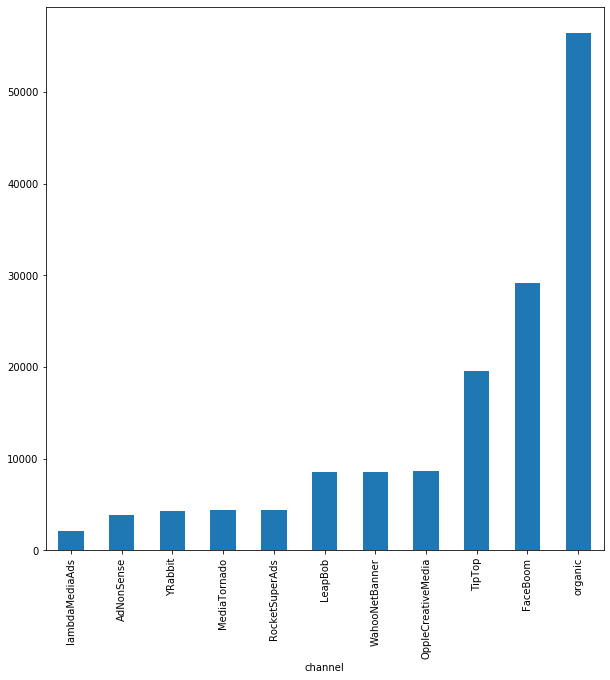

In [28]:
# По каким рекламным каналам шло привлечение пользователей? 
display(profiles.groupby('channel')['channel'].count().sort_values())
profiles.groupby('channel')['channel'].count().sort_values().plot(kind='bar', figsize=(10,10))

Меньше всего посетителей перешло с канала lambdaMediaAds. Больше всего с огранического траффика и каналов FaceBoom и TipTop

channel
MediaTornado           156
YRabbit                165
lambdaMediaAds         225
OppleCreativeMedia     233
LeapBob                262
RocketSuperAds         352
AdNonSense             440
WahooNetBanner         453
organic               1160
TipTop                1878
FaceBoom              3557
Name: channel, dtype: int64

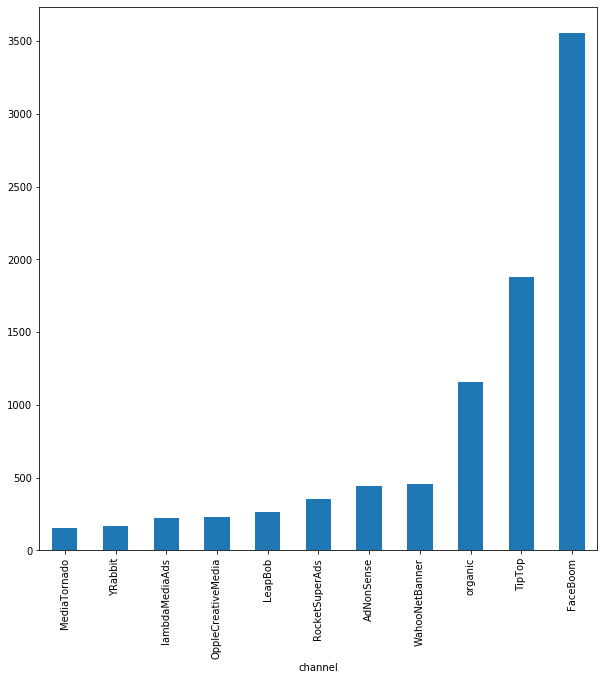

In [29]:
# Какие каналы приносят больше всего платящих пользователей
display(profiles[profiles['payer'] == True].groupby('channel')['channel'].count().sort_values())
profiles[profiles['payer'] == True].groupby('channel')['channel'].count().sort_values().plot(kind='bar', figsize=(10,10))

Больше всего пользователей совершили покупки с каналов FaceBoom, TipTop и с органического траффика. Меньше всего пользователей совершили покупки с канала MediaTornado.

In [30]:
# Таблица, отражающая общее количество пользователей и долю платящих по каналам привлечения
channel_table = (
    profiles.groupby('channel')
    .agg({'user_id': 'count', 'payer': 'sum'})
    .reset_index()
    .rename(columns={'user_id': 'users', 'payer': 'payers'})
)    
channel_table['percentage_of_payers'] = channel_table['payers'] / channel_table['users'] * 100

display(channel_table.sort_values(by='percentage_of_payers'))

,channel,users,payers,percentage_of_payers
10,organic,56439,1160.0,2.055316
4,OppleCreativeMedia,8605,233.0,2.707728
2,LeapBob,8553,262.0,3.063253
3,MediaTornado,4364,156.0,3.574702
8,YRabbit,4312,165.0,3.826531
7,WahooNetBanner,8553,453.0,5.296387
5,RocketSuperAds,4448,352.0,7.913669
6,TipTop,19561,1878.0,9.600736
9,lambdaMediaAds,2149,225.0,10.469986
0,AdNonSense,3880,440.0,11.340206


Лучшие показатели для FaceBoom, AdNonSense, lambdaMediaAds и TipTop. Худший для органического траффика

[К оглавлению](#content)

<a id='market'></a>
## Маркетинг 

In [31]:
# Всего потрачено денег на рекламную компанию
total_costs = profiles['acquisition_cost'].sum()
print('Всего потрачено денег на рекламную компанию', int(total_costs))

Всего потрачено денег на рекламную компанию 105497


'Потрачено денег на каждый источник траффика'

channel
organic                   0.00
YRabbit                 944.22
MediaTornado            954.48
lambdaMediaAds         1557.60
LeapBob                1797.60
RocketSuperAds         1833.00
OppleCreativeMedia     2151.25
AdNonSense             3911.25
WahooNetBanner         5151.00
FaceBoom              32445.60
TipTop                54751.30
Name: acquisition_cost, dtype: float64

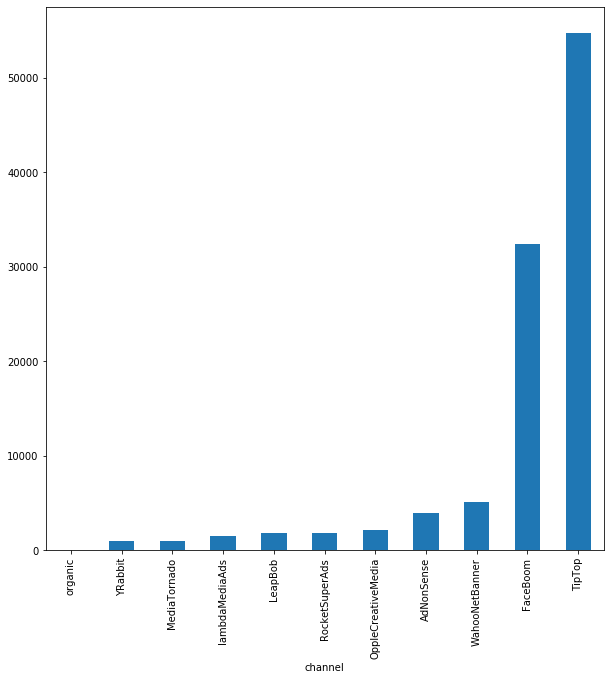

In [32]:
# Потрачено денег на каждый источник траффика
channel_costs = profiles.groupby('channel')['acquisition_cost'].sum().sort_values()
display('Потрачено денег на каждый источник траффика', channel_costs)
channel_costs.plot(kind = 'bar', figsize=(10, 10))

Больше половины рекламного бюджета ушла на канал TipTop, больше четверти на канал FaceBoom. 

region
Germany           4424.223235
UK                5068.502819
France            5075.973946
United States    90928.600000
Name: acquisition_cost, dtype: float64

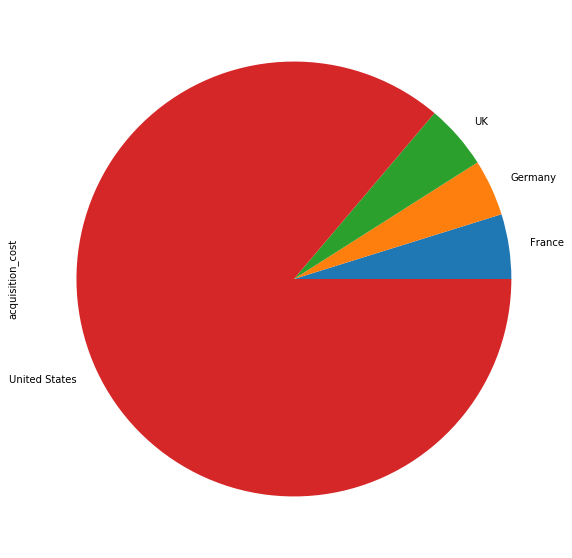

In [33]:
# потрачено денег на рекламу в каждой из стран
display(profiles.groupby('region')['acquisition_cost'].sum().sort_values())
profiles.groupby('region')['acquisition_cost'].sum().plot(kind = 'pie', figsize=(10, 10))

Больше всего денег уходит на рекламу в США (около 5/6) 

In [34]:
# потрачено денег на рекламу в различных каналах в каждой из стран
profiles.pivot_table(index='channel', columns='region', values='acquisition_cost', aggfunc='sum')

region,France,Germany,UK,United States
channel,,,,
AdNonSense,1376.316788,1229.282545,1305.650668,NaN
FaceBoom,NaN,NaN,NaN,32445.60
LeapBob,628.045578,529.946557,639.607864,NaN
MediaTornado,NaN,NaN,NaN,954.48
OppleCreativeMedia,747.336327,640.733464,763.180209,NaN
RocketSuperAds,NaN,NaN,NaN,1833.00
TipTop,NaN,NaN,NaN,54751.30
WahooNetBanner,1789.137006,1552.972718,1808.890277,NaN
YRabbit,NaN,NaN,NaN,944.22


В Европе и США каналы привлечения пользователей абсолютно разные. Самый затратные каналы TipTop и FaceBoom в США

channel
organic               0.00
YRabbit             944.22
MediaTornado        954.48
RocketSuperAds     1833.00
FaceBoom          32445.60
TipTop            54751.30
Name: acquisition_cost, dtype: float64

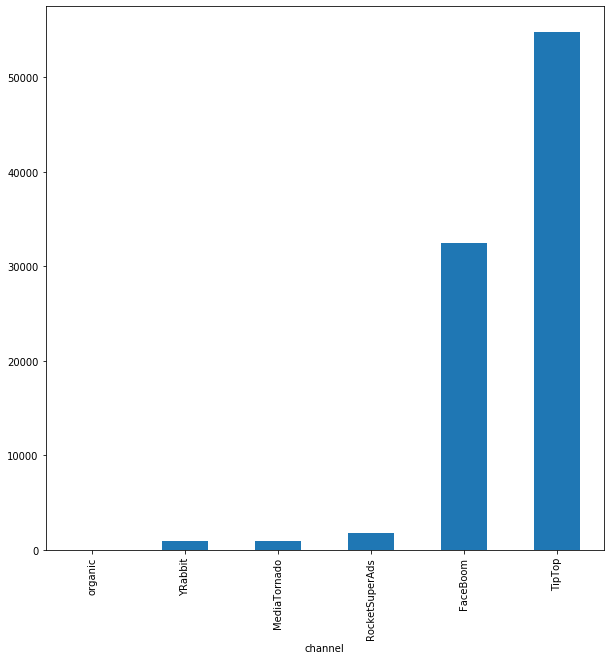

In [35]:
# Потрачено денег на рекламу в каждом канале в США
display(profiles[profiles['region'] == 'United States'].groupby('channel')['acquisition_cost'].sum().sort_values())
(profiles[profiles['region'] == 'United States'].groupby('channel')['acquisition_cost'].sum().sort_values()
.plot(kind = 'bar', figsize=(10, 10)))

В США представлены всего 5 рекламных площадок (помимо органического траффика): TipTop, FaceBoom, YRabbit, MediaTornado и       
RocketSuperAds. Чуть меньше 2/3 рекламного бюджета уходит на рекламу в TipTop, около 1/3 на рекламу в FaceBoom.

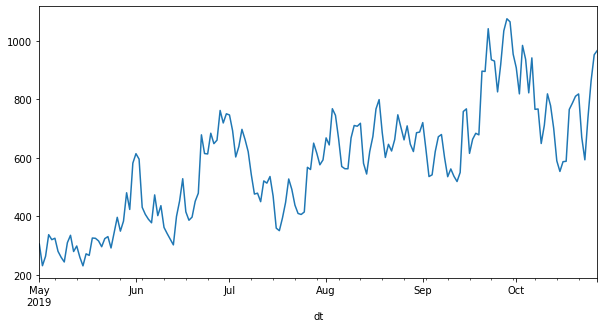

In [36]:
# Распределение затрат на рекламу по времени
time_costs = profiles.groupby('dt')['acquisition_cost'].sum()
time_costs.plot(figsize=(10, 5))

Отмечается рост затрат на рекламу с мая по ноябрь примерно в три раза. Проверим, на какие именно каналы растут расходы на рекламу

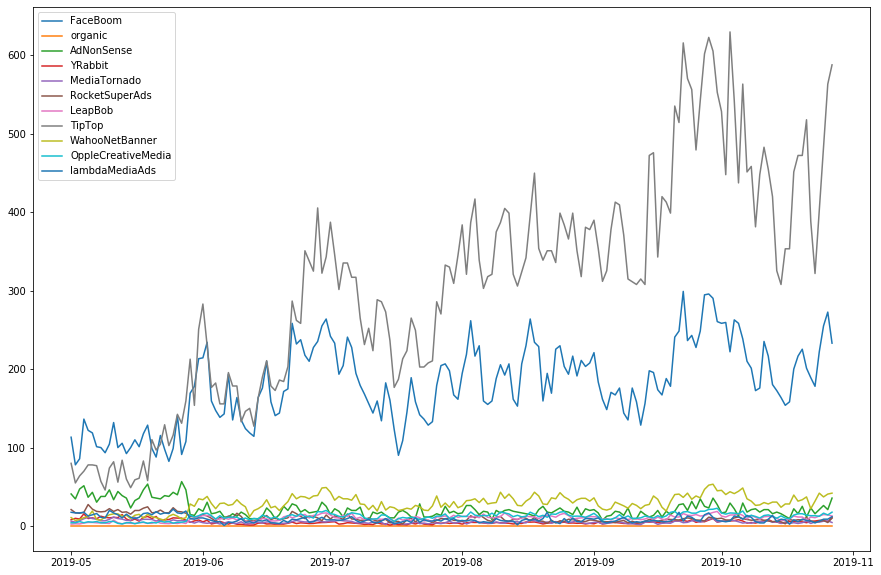

In [37]:
# посмотрим динамику расходов на рекламу в различных каналах по времени
fig, axs = plt.subplots(figsize = (15, 10))

for item in profiles['channel'].unique():
    axs.plot(profiles[profiles['channel'] == item].groupby('dt')['acquisition_cost'].sum(), label=item)
    axs.legend()

Существенно выросли раходы на рекламу в TipTop и FaceBoom. Проверим, в каких странах растут раходы на рекламу

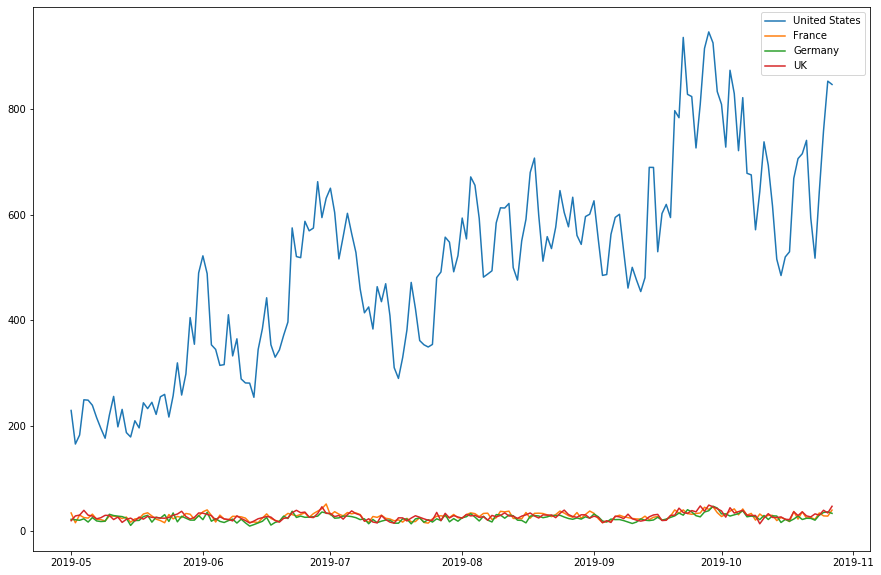

In [38]:
# посмотрим динамику расходов на рекламу в различных странах по времени
fig, axs = plt.subplots(figsize = (15, 10))

for item in profiles['region'].unique():
    axs.plot(profiles[profiles['region'] == item].groupby('dt')['acquisition_cost'].sum(), label=item)
    axs.legend()

Существенно выросли расходы на рекламу в США

'Потрачено денег на каждый источник траффика'

channel
organic               0.000000
LeapBob               0.210172
MediaTornado          0.218717
YRabbit               0.218975
OppleCreativeMedia    0.250000
RocketSuperAds        0.412095
WahooNetBanner        0.602245
lambdaMediaAds        0.724802
AdNonSense            1.008054
FaceBoom              1.113286
TipTop                2.799003
dtype: float64

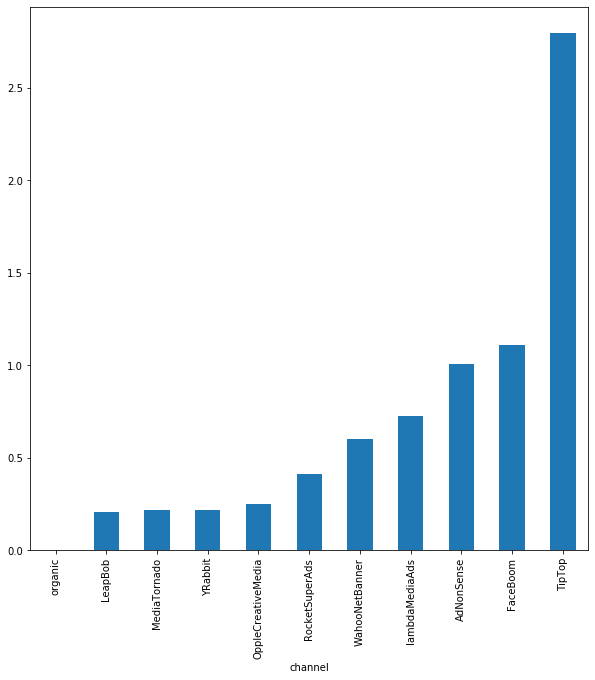

In [39]:
# средняя стоимость привлечения одного покупателя из каждого источника
user_costs = (profiles.groupby('channel')['acquisition_cost'].sum()/profiles.groupby('channel')['user_id'].count()).sort_values()
display('Потрачено денег на каждый источник траффика', user_costs)
user_costs.sort_values().plot(kind = 'bar', figsize=(10, 10))

Самая дорогая стоимость привлечения клиента на площадках TipTop (около 1/3), FaceBoom, AdNonSense. При этом, больше половины рекламного бюджета было потрачено на канал TipTop. Возможно, это убыточный канал

Самая дешевая стоимость привлечения клиента, помимо органического траффика, на площадках LeapBob, MediaTornado, YRabbit

[К оглавлению](#content)

<a id='estimates'></a>
## Оценка окупаемости рекламы для привлечения пользователей

In [40]:
# зададим момент и горизонт анализа
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

# отфильтруем органический трафик из датасета
profiles_without_organic = profiles[profiles['channel'] != 'organic']

<a id='5-1'></a>
### Общая окупаемость рекламы

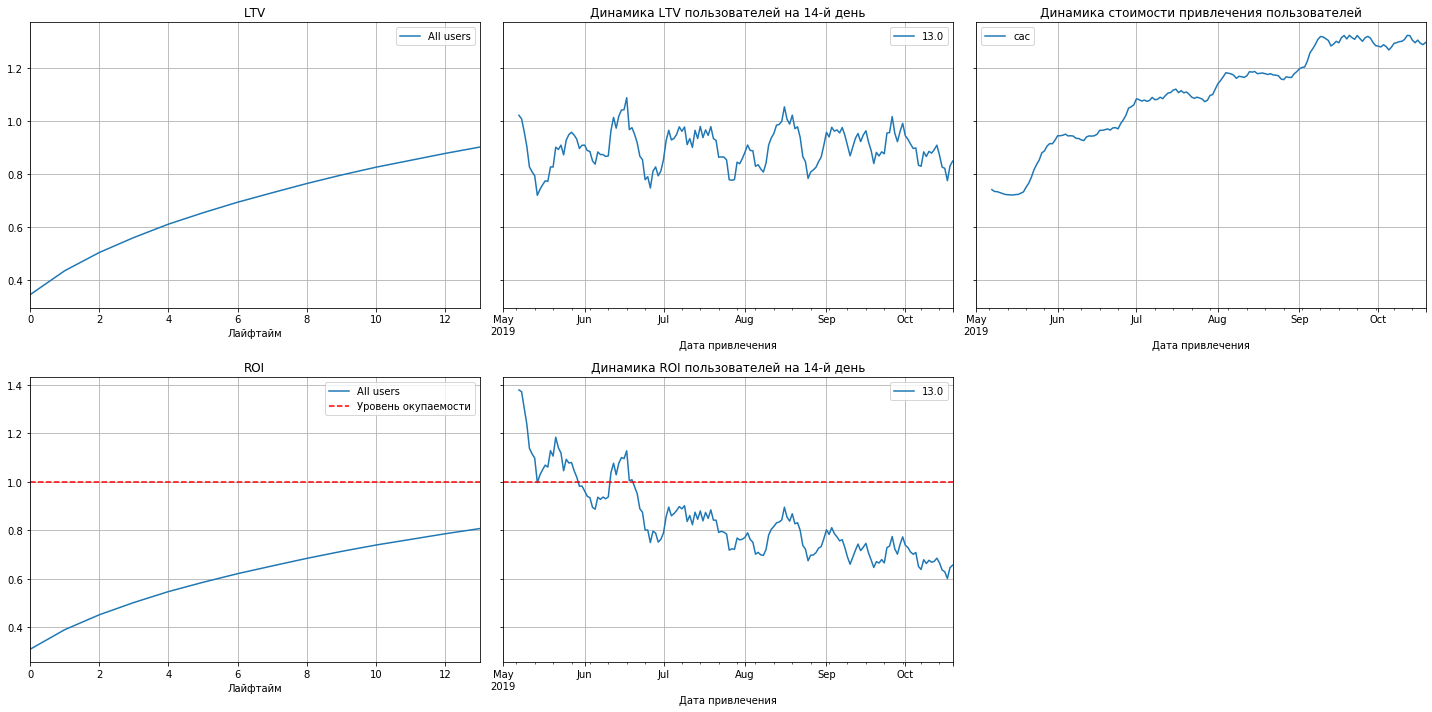

In [41]:
# Общая окупаемость рекламы

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_without_organic, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Из графиков можно сделать такие выводы:

Реклама не окупается. ROI на 14й день около 80%. 

CAC скачкообразно вырос в конце мая, затем продолжил монотонно увеличиваться. И с ростом CAC ROI падает ниже уровня окупаемости. Возможно, рекламные бюджеты вкладываются в неэффективные каналы привлечения пользователей или была запущена неэффективная рекламная компания

На LTV влияет сезонный фактор, но этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей. Проверим расходы на рекламу 

[К оглавлению](#content)

<a id='5-2'></a>
### Анализ окупаемости рекламы с разбивкой по устройствам

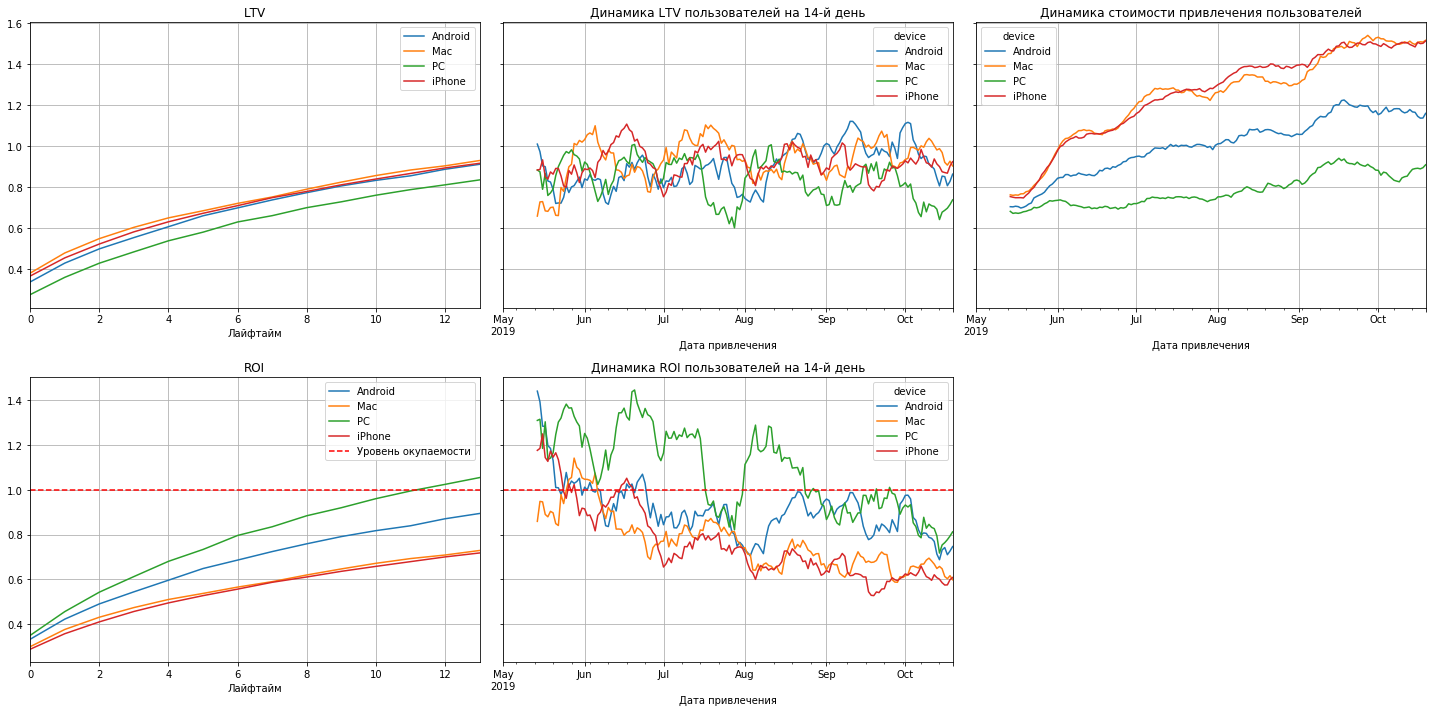

In [42]:
# окупаемость рекламы с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_without_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Реклама не окупается всех устройствах, кроме PC. Динамика стоимости привлечения пользователей возрастает и динамика ROI снижается на всех устройствах, быстрее всего на iPhone и Mac. Проверим распределение расходов на рекламу среди устройств в каждой из стран

In [43]:
# распределение расходов на рекламу среди устройств в каждой из стран в % 
(
 profiles.pivot_table(index='device', columns='region', values='acquisition_cost', aggfunc='sum') / 
 profiles['acquisition_cost'].sum() * 100
)

region,France,Germany,UK,United States
device,,,,
Android,1.442450,1.216782,1.409025,17.221984
Mac,0.503076,0.467789,0.459434,21.408709
PC,1.899064,1.681528,1.954363,8.933041
iPhone,0.966882,0.827585,0.981569,38.626719


Расходы на рекламу на всех устройствах значительно больше в США, чем в Европе 

[К оглавлению](#content)

<a id='5-3'></a>
### Окупаемость рекламы с разбивкой по странам

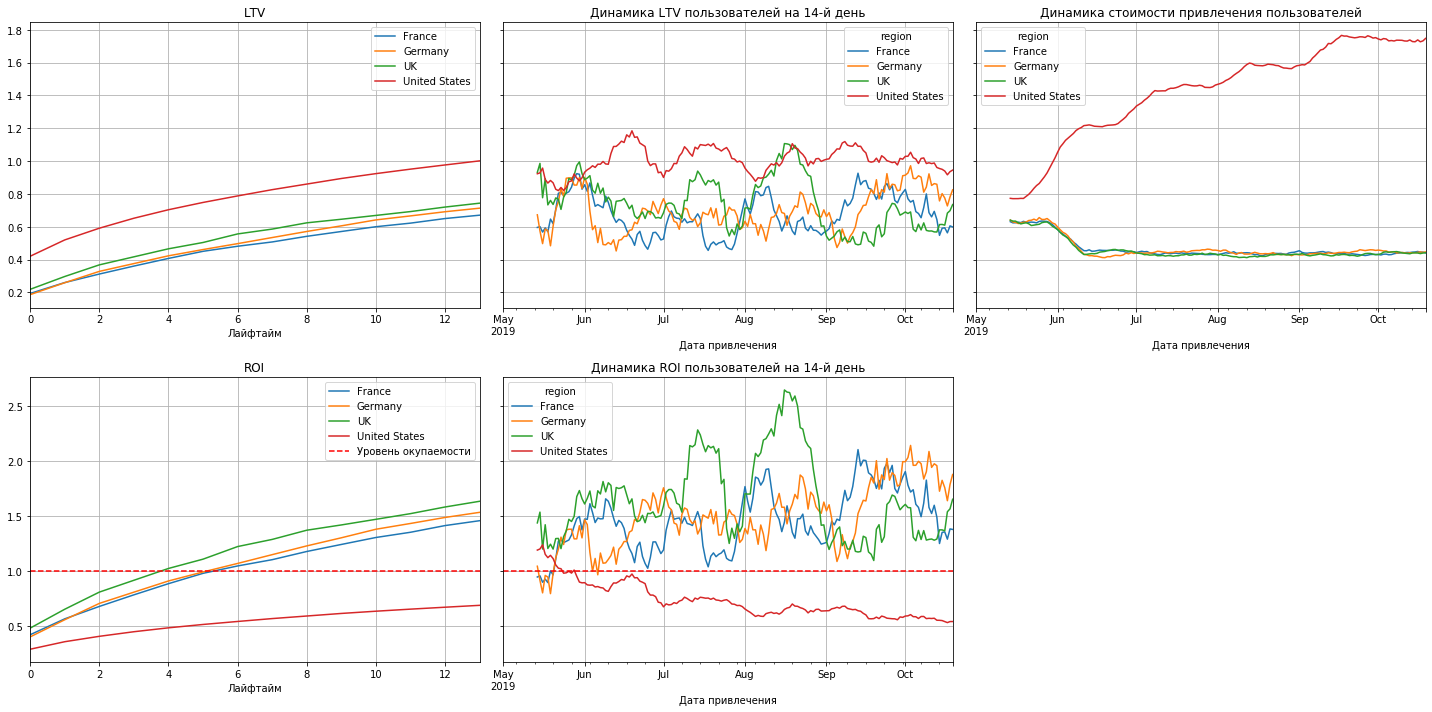

In [44]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_without_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Стоимость привлечения пользователей аномально высокая для США по сравнению с другими странами. ROI убыточен только для США

Начиная с конца мая стоимость привлечения клиентов в США растет, в то время как в Европе она снизилась

[К оглавлению](#content)

<a id='5-4'></a>
### Окупаемость рекламы с разбивкой по источникам привлечения

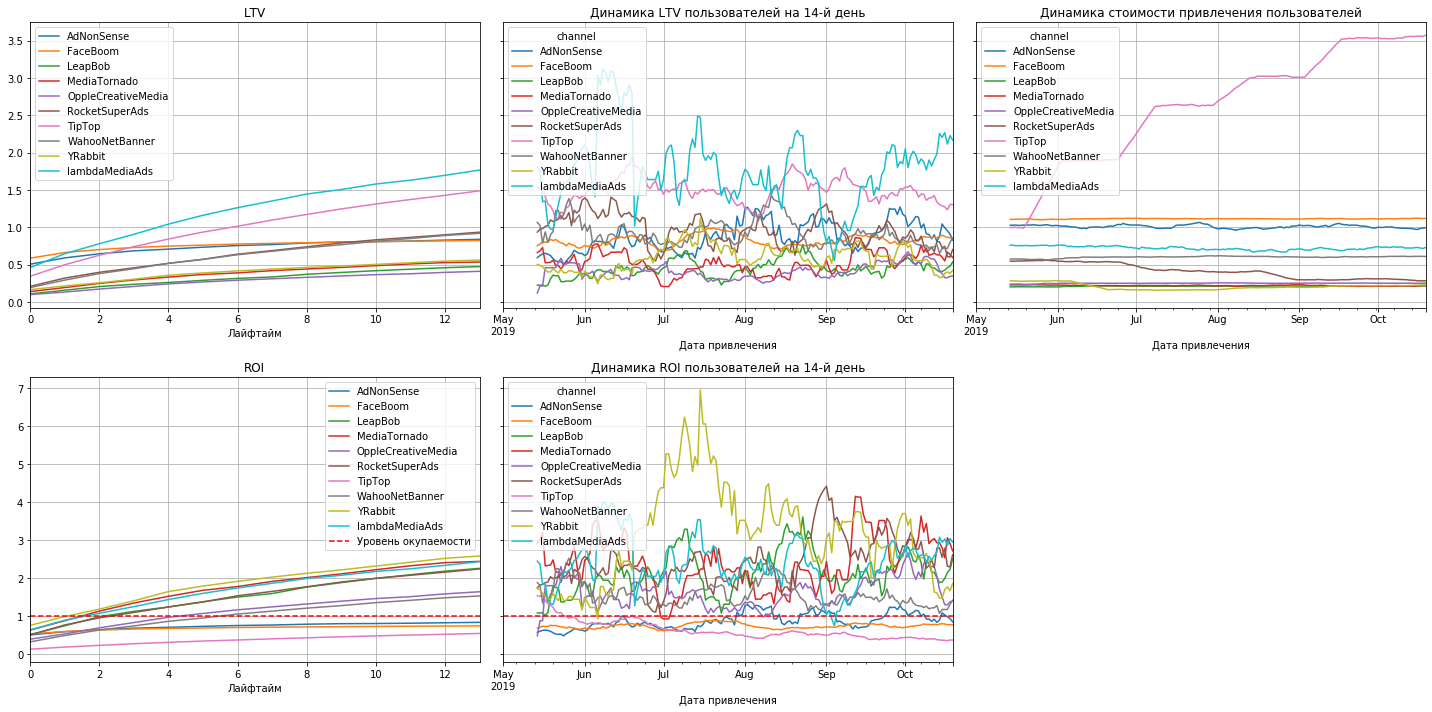

In [45]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_without_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

По сравнению с другими источниками, аномально растет стоимость привлечения стоимости пользователя из канала TipTop. Убыточные каналы (ROI < 1) - TipTop, FaceBoom, AdNonSense

[К оглавлению](#content)

<a id='5-5'></a>
### Конверсия и удержание клиентов с разбивкой по устройствам

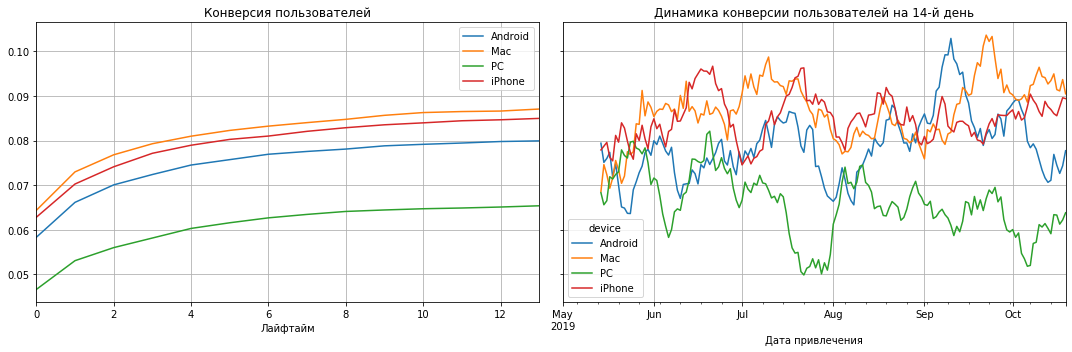

In [46]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_without_organic, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion, conversion_history, horizon_days, window=14)

Самая высокая конверсия на MAC и IPhone, немногим меньше для Android. самая низкая на PC

[К оглавлению](#content)

<a id='5-6'></a>
### Конверсия и удержание клиентов с разбивкой по странам

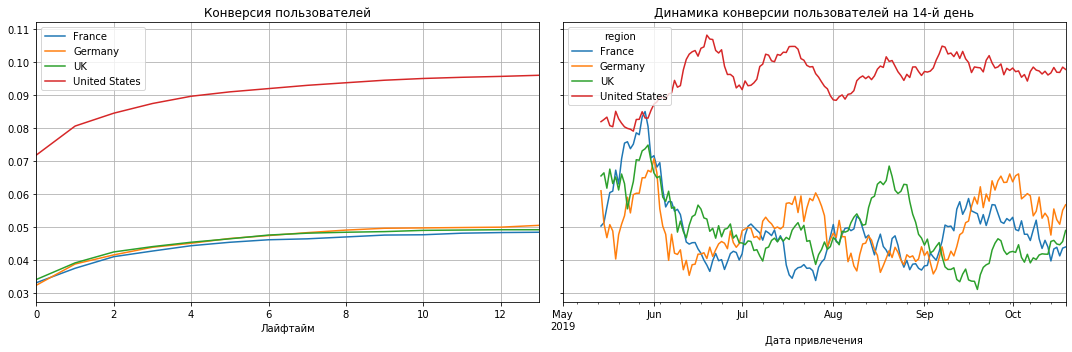

In [47]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_without_organic, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion, conversion_history, horizon_days, window=14)

Конверсия в США сильно выше чем конверсия в других странах

[К оглавлению](#content)

<a id='5-7'></a>
### Конверсия и удержание клиентов с разбивкой по рекламным каналам

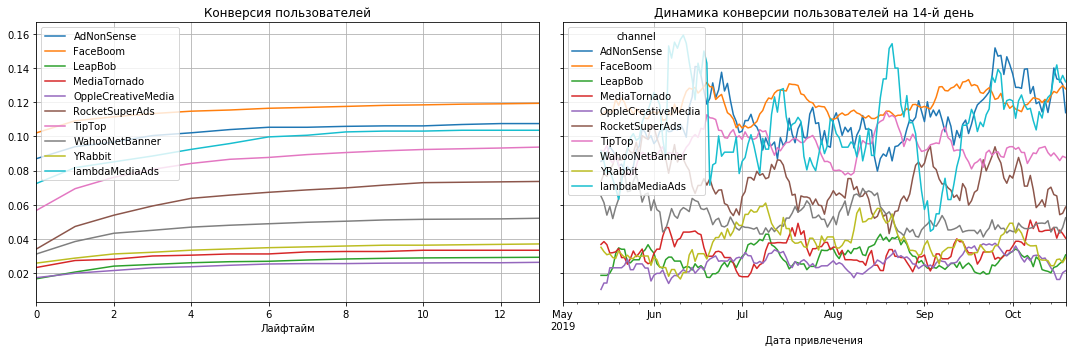

In [48]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_without_organic, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion, conversion_history, horizon_days, window=14)

Самая высокая конверсия на FaceBoom, далее AdNonSense lambdaMediaAds и TipTop. Самая низкая для LeapBob и OppleCreativeMedia

[К оглавлению](#content)

<a id='outcome'></a>
## Вывод

Реклама, направленная на привлечение пользователей, в целом не окупается. При этом стоимость привлечения клиента (CAC) растет, а LTV существенно не меняется. 

Возможно, в конце мая был запуск новой рекламной компании о чем свидетельствуют следующие факторы: 
 - отмечается существенный рост инвестиций в США, при этом в другие страны инвестиции не возрастают
 - отмечается существенный рост инвестиций в рекламные каналы TipTop и FaceBoom, инвестиции в другие каналы не возрастают
 - каналы привлечения пользователей в Европе и США абсолютно разные. Каналы TipTop и FaceBoom присутсвуют только в США и отсутствуют в Европе
 

В целом, больше всего денег потрачено на привлечение пользователей из США - примено 5/6 всего рекламного бюджета. Из них около 2/3 потрачено на рекаму в TipTop, около 1/3 на рекламу в FaceBoom. Больше всего пользователей (около 2/3) и покупателей (около 3/4) пришло из США. Покупатели из США принесли около 2/3 прибыли. При этом стоимость привлечения пользователя аномально высокая для США, по сравнению с другими странами. ROI убыточен только для США. Таким образом, рекламная компания в США убыточна, несмотря на самую высокую конверсию по сравнению с другими странами

При анализе всех стран, больше всего переходов и покупок с Faceboom, органического траффика и TipTop. Больше всего денег потрачено на рекламу в TipTop (больше половины), около трети на FaceBoom. При этом затраты на рекламу в TipTop и FaceBoom растут на протяжении всего периода исследования. Аномально растет стоимость привлечения пользователей из канала TipTop по сравнению с другими каналами. Каналы привлечения TipTop, FaceBoom и AdNonSense убыточны

Реклама не окупается на устройствах, кроме PC. Что закономерно, потому как расходы на рекламу значительно больше представлены в США (где рекламная компания не окупается), чем в Европе. Больше всего покупателей с IPhone, затем идут Android, MAC И PC. Дороже всего привлечение пользователей на IPhone и MAC, дешевле всего на PC. Конверсия на MAC, IPhone и Android выше чем на PC, что исключает возможность влияния на убыточность рекламной компании технической неисправности

Самая высокая конверсия для каналов FaceBoom, далее AdNonSense, lambdaMediaAds и TipTop. Самая низкая для LeapBob и OppleCreativeMedia. Конверсия в США существенно выше чем в других странах. 

**Вывод: рекламная компания в США является убыточной из-за каналов TipTop и FaceBoom, в Европе убыточным является канал AdNonSense.** Маркетологам стоит рассмотреть возможность перераспределения затрат на рекламу:
 - с США в Европу 
 - с каналов TipTop, FaceBoom и AdNonSense на другие каналы
 
 
Возможно стоит изменить настройки таргета в убыточных каналах

[К оглавлению](#content)